In [ ]:
from pharynx_analysis import (pharynx_io as pio, image_processing as ip, experiment, plots)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import xarray as xr
from importlib import reload
from skimage import measure, transform
from collections import namedtuple
import pdb
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import scale
import pandas as pd
from scipy.signal import find_peaks
from pprint import pprint
from pathlib import Path
from skimage import io as skio
import matplotlib.patches as patches

from scipy.spatial import distance

import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

reload(pio);
reload(ip);
reload(experiment);
reload(plots);

dir_path = Path(
    "/Users/sean/code/wormAnalysis/data/paired_ratio/2019_04_03_ASI_ablation"
)

In [57]:
ex = experiment.PairExperiment(dir_path,"TL/470/410/470/410")
ex.full_pipeline()

01:15:43 INFO:Starting full pipeline run for /Users/sean/code/wormAnalysis/data/paired_ratio/2019_04_03_ASI_ablation
01:15:43 INFO:Loading Images
01:15:44 INFO:Segmenting pharynxes
01:15:45 INFO:Centering and rotating pharynxes
100%|██████████| 123/123 [00:08<00:00, 14.90it/s]
01:15:54 INFO:Calculating midlines
100%|██████████| 123/123 [00:01<00:00, 113.31it/s]
01:15:55 INFO:Measuring under midlines
100%|██████████| 123/123 [00:04<00:00, 29.27it/s]
01:16:02 INFO:Registering profiles
01:16:18 INFO:Trimming intensity data
01:16:20 INFO:Calculating redox measurements
01:16:20 INFO:Finished full pipeline run for /Users/sean/code/wormAnalysis/data/paired_ratio/2019_04_03_ASI_ablation


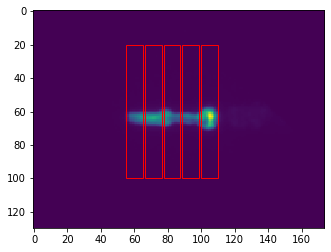

In [67]:
ax = plt.imshow(ex.rot_fl.sel(pair=0, wavelength='410').isel(strain=0))

plt.

bbox_xs = np.linspace(55, 100, 5)
for x in bbox_xs:
    rect = patches.Rectangle((x, 20), 10, 80, edgecolor='r', linewidth=1, facecolor='none')
    plt.gca().add_patch(rect)

In [47]:
reload(pio);
reload(ip);
reload(experiment);
reload(plots);
ex_cata = experiment.CataExperiment(dir_path, "TL/470/410/470/410")
ex_cata.full_pipeline()

12:51:14 INFO:Starting full pipeline run for /Users/sean/code/wormAnalysis/data/paired_ratio/2019_04_03_ASI_ablation
12:51:14 INFO:Loading Images
12:51:15 INFO:Segmenting pharynxes
12:51:18 INFO:Centering and rotating pharynxes
100%|██████████| 123/123 [00:07<00:00, 15.86it/s]
12:51:27 INFO:Trimming intensity data


AttributeError: 'NoneType' object has no attribute 'strain'

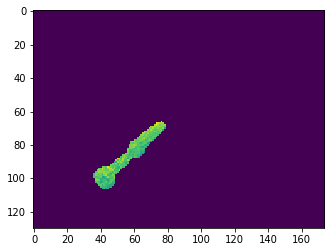

In [28]:
ref_wvl = '410'

for animal_idx in np.arange(ex.seg_images.strain.size):
    for wvl_idx in np.arange(ex.seg_images.wavelength.size):
        for pair in ex.seg_images.pair:
            ref_seg = ex.seg_images.sel(wavelength=ref_wvl, pair=pair).isel(strain=animal_idx)
            img = ex.raw_image_data.sel(wavelength=wvl, pair=pair).isel(strain=animal_idx)
            
            masked = ref_seg * img
            
            ex.raw_image_data[animal_idx, wvl_idx, pair] = masked



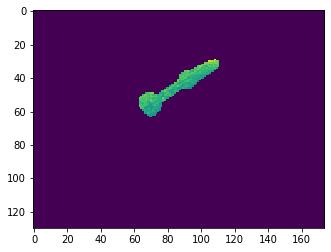

In [34]:
plt.imshow((ex.raw_image_data).sel(wavelength='470', pair=0).isel(strain=3))

In [20]:
np.max(ex.seg_images.values.astype(np.uint8))

1

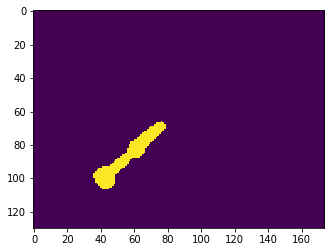

In [14]:
plt.imshow(ex.seg_images.sel(pair=0, wavelength='410').isel(strain=0))

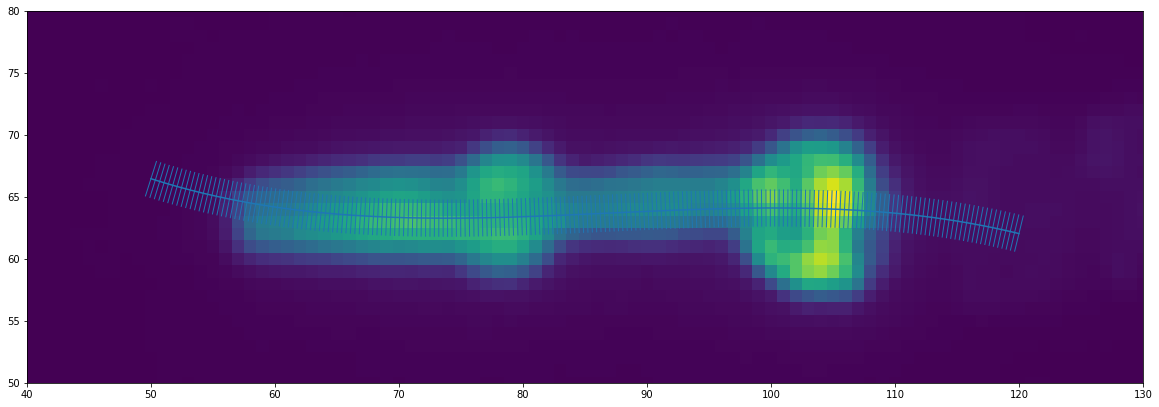

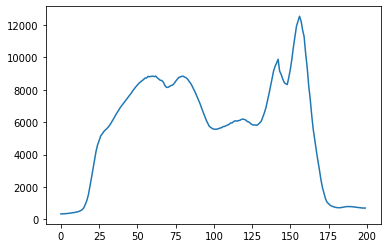

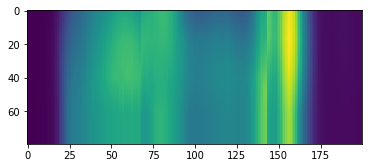

In [246]:
i = 3
I = ex.rot_fl.sel(wavelength='410', pair=0).isel(strain=i)
mid = mids[i]['410'][0]
der = mid.derivative()

xs = np.linspace(50, 120, 200)
ys = mid(xs)

normal_slopes = -1/der(xs)
normal_thetas = np.arctan(normal_slopes)

mag = 1.5
x0 = np.cos(normal_thetas) * mag
y0 = np.sin(normal_thetas) * mag

x1 = np.cos(normal_thetas) * -mag
y1 = np.sin(normal_thetas) * -mag

xs0 = xs + x0
xs1 = xs + x1
ys0 = ys + y0
ys1 = ys + y1

lines = [list(x) for x in zip(zip(xs0, ys0), zip(xs1, ys1))]
lc = LineCollection(lines, linewidths=1)
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(I)
ax.plot(xs, ys)
ax.add_collection(lc)
ax.set_aspect('equal')
ax.set_xlim(40,130)
ax.set_ylim(50,80)

prof = [
    np.mean(
        measure.profile_line(
            I,
            (xs0[i], ys0[i]), (xs1[i], ys1[i]), order=1, linewidth=1
        )
    )
    for i in range(len(xs0))
]
straightened = []
for i in range(len(xs0)):
    line = measure.profile._line_profile_coordinates((xs0[i], ys0[i]), (xs1[i], ys1[i]))[:,:,0]
    xs = xr.DataArray(line[0], dims='z')
    ys = xr.DataArray(line[1], dims='z')
    straightened.append(ip.trim_profile(I.interp(x=xs, y=ys).data, 0, 80))
straightened = np.stack(straightened).T
prof = np.mean(straightened, axis=0)
plt.figure()
plt.plot(prof);
plt.figure()
plt.imshow(np.stack(straightened));

# Compare line thickness errors

In [440]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [441]:
from scipy.stats import norm

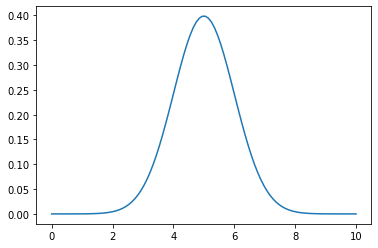

In [465]:
vector_length = 10
rv = norm(loc = vector_length/2, scale = vector_length/10)
x = np.linspace(0, vector_length, 100)
plt.plot(x, rv.pdf(x))

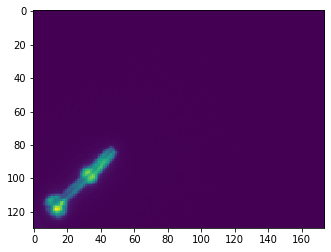

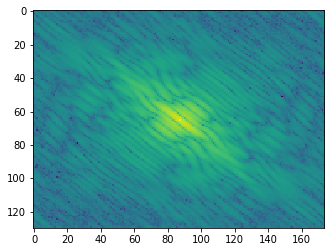

In [261]:
from skimage.transform import frt2

i410 = ex.raw_image_data.sel(wavelength='410', pair=0).isel(strain=0)
plt.imshow(i410)
FS = np.fft.fft2(i410.data)
plt.figure()
plt.imshow(np.log(np.abs(np.fft.fftshift(FS))**2))

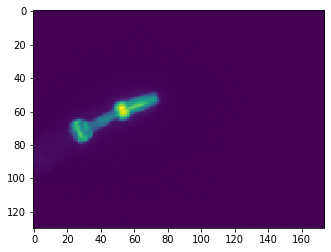

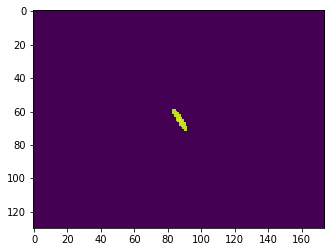

In [353]:
from skimage.transform import frt2

i410 = ex.raw_image_data.sel(wavelength='470', pair=0).isel(strain=40)
plt.imshow(i410)
FS = np.fft.fft2(i410.data)
scaled_fs = np.log(np.abs(np.fft.fftshift(FS)))
scaled_fs[scaled_fs<14] = 0
plt.figure()
plt.imshow(scaled_fs);

In [74]:
df = pd.DataFrame(columns=ex.scaled_regions.keys())
for name, bounds in ex.scaled_regions.items():
    df[name] = 0

{'pm7': array([ 7, 13]),
 'pm6': array([15, 21]),
 'pm5': array([25, 47]),
 'pm4': array([53, 64]),
 'pm3': array([68, 93])}

In [96]:
reg = ex.scaled_regions['pm7']
ex.trimmed_intensity_data.shape
ex.trimmed_intensity_data[:,:,:,reg[0]:reg[1]].mean(dim='position').isel(pair=0).to_pandas().to_csv('/Users/sean/Desktop/region_means.csv')

In [94]:
ex.scaled_regions.values()

dict_values([array([ 7, 13]), array([15, 21]), array([25, 47]), array([53, 64]), array([68, 93])])